## BRENDA pH activity data
- BRENDA has "pH optimum" and "pH range" fields
- We need to match up the data from these two sheets
- This notebook will parse the "pH optimum" data and match it with the ph range data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import re
import regex
from tqdm.auto import tqdm

In [ ]:
inputs_dir = Path("/projects/robustmicrob/jlaw/inputs/brenda/202301_tables")
data_dir = "/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/brenda"

In [2]:
ph_range_file = inputs_dir / "202301_ph_opt.tsv.gz"
header = ["ec_num", "name", "ph_min", "ph_max", "comments", "organism", "uniprot_id", "ref", "empty"]
data = pd.read_csv(ph_range_file, sep='\t', names=header)
data = data.drop(columns=['empty'])
print(len(data))
data = data[data.ph_min != "additional information"]
# data = data[data.ph_min != "additional information"]
print(len(data))
data.head(2)

51028
50084


,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref
2,1.1.1.1,alcohol dehydrogenase,3,-,reduction of aldehydes,Thermococcus kodakarensis,Q5JI09,735486
3,1.1.1.1,alcohol dehydrogenase,3.8,-,-4.3,Neurospora crassa,-,659773


In [3]:
data.organism.value_counts()

Homo sapiens                    3979
Rattus norvegicus               2213
Escherichia coli                1885
Bos taurus                      1029
Saccharomyces cerevisiae        1013
                                ... 
Palaemon serratus                  1
Parophrys vetulus                  1
Pleuronichthys verticalis          1
Pseudopleuronectes yokohamae       1
Acyrthosiphon pisum                1
Name: organism, Length: 5906, dtype: int64

#### Find a uniprot ID for rows where it's missing
See if we can use the mapping from the uniprot ID's ec numbers to get a protein

In [4]:
uniprot_ec_file = f"{data_dir}/uniprot/uniprotkb_ec_AND_reviewed_true_2023_07_06.tsv.gz"
uniprot_ec_df = pd.read_table(uniprot_ec_file)
print(len(uniprot_ec_df))
uniprot_ec_df.head(2)

274744


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,EC number
0,A0A009IHW8,reviewed,ABTIR_ACIB9,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,J512_3302,Acinetobacter baumannii (strain 1295743),269,3.2.2.-; 3.2.2.6
1,A0A023I7E1,reviewed,ENG1_RHIMI,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,796,3.2.1.39


In [5]:
data_no_uniprot = data[data.uniprot_id == "-"]
len(data_no_uniprot)

36326

In [6]:
data_matched_uniprot = pd.DataFrame()
for ec_num, df in tqdm(data_no_uniprot.groupby('ec_num')):
    uniprot_ec_rows = uniprot_ec_df[uniprot_ec_df['EC number'].apply(lambda x: ec_num in x.split('; '))]
    if len(uniprot_ec_rows) == 0:
        continue

    org_count = df.organism.value_counts().to_dict()
    
    def match_uniprot_ec_organism(org, 
                                  num_brenda_org_cutoff=2,
                                  num_matching_rows_cutoff=2):
        # only try and automatically match for brenda entries that have fewer than 3 entries for the same enzyme
        if org_count[org] > num_brenda_org_cutoff:
            return np.nan

        matching_rows = uniprot_ec_rows[uniprot_ec_rows.Organism.apply(lambda x: org in x)]
        if len(matching_rows) > num_matching_rows_cutoff:
            return np.nan

        return ",".join(matching_rows.Entry.values)

    df['uniprot_id'] = df.organism.apply(match_uniprot_ec_organism)
    data_matched_uniprot = pd.concat([data_matched_uniprot, df])

print(len(data_matched_uniprot))

  0%|          | 0/4539 [00:00<?, ?it/s]

33505


In [7]:
data_matched_uniprot.uniprot_id = data_matched_uniprot.uniprot_id.replace("",np.nan)
data_matched_uniprot = data_matched_uniprot.dropna(subset='uniprot_id')

In [8]:
print(len(data_matched_uniprot), data_matched_uniprot.uniprot_id.nunique())

5469 4268


In [109]:
data_uniprot = data[data.uniprot_id != '-'].dropna(subset='uniprot_id')
print(len(data_uniprot), data_uniprot.uniprot_id.nunique())
data_uniprot = pd.concat([data_uniprot, data_matched_uniprot])
print(len(data_uniprot), data_uniprot.uniprot_id.nunique())
data_uniprot = data_uniprot.drop_duplicates()
print(len(data_uniprot), data_uniprot.uniprot_id.nunique())

13756 10465
19225 14208
19225 14208


In [110]:
data_uniprot.uniprot_id.value_counts()

Q51723           17
P08659           14
P00784           13
Q9AJE3           11
O23791           11
                 ..
Q5AVY9            1
Q9KIF2            1
B3VS85            1
C7A621            1
P97046,Q9CHL8     1
Name: uniprot_id, Length: 14208, dtype: int64

In [111]:
# split rows with multiple uniprot IDs
data_uniprot["uniprot_id"] = data_uniprot.uniprot_id.apply(lambda x: x.replace(' AND ',',').replace(' and ',',').replace(' ','').split(','))
data_uniprot = data_uniprot.explode(column='uniprot_id', ignore_index=True)
print(len(data_uniprot), data_uniprot.uniprot_id.nunique())

24931 15909


In [112]:
data_uniprot.uniprot_id.value_counts()

P27169    34
Q975F9    33
Q51723    20
P08659    19
Q9NR71    19
          ..
Q9W197     1
B3GK03     1
Q9Z2D1     1
Q7UIS7     1
Q9CHL8     1
Name: uniprot_id, Length: 15909, dtype: int64

In [17]:
data_uniprot[data_uniprot.uniprot_id == "P27169"]

,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref
9203,3.1.1.2,arylesterase,7.4,-,assay at,Homo sapiens,P27169,"35213, 665028, 678376, 681730"
9204,3.1.1.2,arylesterase,7.4,-,assay at,Homo sapiens,P27169,"35213, 665028, 678376, 681730"
9208,3.1.1.2,arylesterase,8,-,assay at,Homo sapiens,P27169,"35212, 35215, 663985, 664184, 665960, 677411, ..."
9209,3.1.1.2,arylesterase,8,-,assay at,Homo sapiens,P27169,"35212, 35215, 663985, 664184, 665960, 677411, ..."
9210,3.1.1.2,arylesterase,8,-,assay at,Homo sapiens,P27169,"35212, 35215, 663985, 664184, 665960, 677411, ..."
9213,3.1.1.2,arylesterase,8,-,assay at,Homo sapiens,P27169,"35212, 35215, 663985, 664184, 665960, 677411, ..."
9214,3.1.1.2,arylesterase,8,-,assay at,Homo sapiens,P27169,"35212, 35215, 663985, 664184, 665960, 677411, ..."
9215,3.1.1.2,arylesterase,8,-,assay at,Homo sapiens,P27169,"35212, 35215, 663985, 664184, 665960, 677411, ..."
9216,3.1.1.2,arylesterase,8,-,assay at,Homo sapiens,P27169,"35212, 35215, 663985, 664184, 665960, 677411, ..."
9221,3.1.1.2,arylesterase,8.5,-,assay at,Homo sapiens,P27169,"677892, 679634"


In [113]:
out_file = Path(data_dir, "ph_opt/20230907_ph_opt_processed.csv")
data_uniprot.to_csv(out_file, index=False)

Remove the "assay at" rows as well as the mutant rows (for now)

In [114]:
print(len(data_uniprot), data_uniprot.uniprot_id.nunique())
data_uniprot = data_uniprot[data_uniprot.comments.apply(lambda x: "assay at" not in x)]
print(len(data_uniprot), data_uniprot.uniprot_id.nunique())

24931 15909
14176 9903


In [115]:
print(len(data_uniprot), data_uniprot.uniprot_id.nunique())
data_uniprot = data_uniprot[data_uniprot.comments.apply(lambda x: "mutant" not in x)]
print(len(data_uniprot), data_uniprot.uniprot_id.nunique())

14176 9903
13908 9847


In [116]:
out_file = Path(data_dir, "ph_opt/20230907_ph_opt_no_assay_at_no_mutant.csv")
data_uniprot.drop(columns='name').to_csv(out_file, index=False)

### Match the data_opt rows with the ph_range rows
- We should be able to match based on the references

In [117]:
out_file = Path(data_dir, "ph_range/20230907_ph_range_processed_act.csv")
data_act_ph_range = pd.read_csv(out_file)
print(len(data_act_ph_range))
data_act_ph_range

out_file = Path(data_dir, "ph_range/20230907_ph_range_processed.csv")
data_ph_range = pd.read_csv(out_file, index_col=0)
data_ph_range = data_ph_range[data_ph_range.index.isin(data_act_ph_range.exp_index.unique())]
print(len(data_ph_range))

6295
3178


In [118]:
data_act_ph_range

,exp_index,ph,activity,note,ph_range_comment,uniprot_id
0,1,4.0,0.80,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46
1,1,7.5,0.60,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46
2,3,4.9,0.25,reduction reaction,"pH 4.9: about 25% of maximal activity, pH 5.8:...",Q4J702
3,3,5.8,0.40,reduction reaction,"pH 4.9: about 25% of maximal activity, pH 5.8:...",Q4J702
4,4,4.9,0.25,reduction reaction,"pH 4.9: about 25% of maximal activity, pH 5.8:...",Q4J9F2
...,...,...,...,...,...,...
6290,2627,4.0,0.55,NaN,"the enzyme shows 30%, 55%, 100%, 70%, 15% and ...",I6XPK9
6291,2627,5.0,1.00,NaN,"the enzyme shows 30%, 55%, 100%, 70%, 15% and ...",I6XPK9
6292,2627,6.0,0.70,NaN,"the enzyme shows 30%, 55%, 100%, 70%, 15% and ...",I6XPK9
6293,2627,7.0,0.15,NaN,"the enzyme shows 30%, 55%, 100%, 70%, 15% and ...",I6XPK9


In [35]:
data_ph_range

,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref
1,1.1.1.1,alcohol dehydrogenase,4,7.5,"pH 4.0: about 80% of maximal activity, pH 7.5:...",Candida parapsilosis,B2KJ46,684556
3,1.1.1.1,alcohol dehydrogenase,4.9,5.8,"pH 4.9: about 25% of maximal activity, pH 5.8:...",Sulfolobus acidocaldarius,Q4J702,719428
4,1.1.1.1,alcohol dehydrogenase,4.9,5.8,"pH 4.9: about 25% of maximal activity, pH 5.8:...",Sulfolobus acidocaldarius,Q4J9F2,719428
5,1.1.1.1,alcohol dehydrogenase,5.5,7.5,"pH 5.5: about 35% of maximal activity, pH 7.5:...",Sulfurisphaera tokodaii,F9VMI9,718627
7,1.1.1.1,alcohol dehydrogenase,6,-,50% of maximum activity for reduction of aldeh...,Thermococcus kodakarensis,Q5JI09,735486
...,...,...,...,...,...,...,...,...
6382,6.5.1.7,"DNA ligase (ATP, ADP or GTP)",6.5,9,"pH 6.5: about 90% of maximal activity, 9.0: ab...",Hyperthermus butylicus,A2BJX6,727438
6391,7.1.2.2,H+-transporting two-sector ATPase,10,-,ATP synthesis in washed membranes of Haloferax...,Haloferax volcanii,Q48332,727822
6392,7.2.2.10,P-type Ca2+ transporter,5.5,8,about 35% of maximal activity at pH 5.5 and at...,Saccharomyces cerevisiae,P13586,210495
6393,7.2.2.10,P-type Ca2+ transporter,5.5,8,about 35% of maximal activity at pH 5.5 and at...,Saccharomyces cerevisiae,P38929,210495


In [119]:
data_opt_match = data_uniprot[data_uniprot.uniprot_id.isin(data_ph_range.uniprot_id.unique())]
print(len(data_opt_match))
data_opt_match.head(2)

3220


,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref
0,1.1.1.1,alcohol dehydrogenase,3,-,reduction of aldehydes,Thermococcus kodakarensis,Q5JI09,735486
1,1.1.1.1,alcohol dehydrogenase,4.5,-,-,Candida parapsilosis,B2KJ46,684556


In [120]:
ph_range_refs = set([r.strip() for refs in data_ph_range.ref.values for r in refs.split(',')])
print(len(ph_range_refs))

2276


In [121]:
# use the reference to matchup the optimum rather than the uniprot ID
def match_refs(refs):
    if not isinstance(refs, str):
        return np.nan
    for r in refs.replace(' ','').split(','):
        if r in ph_range_refs:
            return r
    return np.nan

data_uniprot['ph_range_ref_match'] = data_uniprot.ref.apply(match_refs)
data_opt_match = data_uniprot.dropna(subset='ph_range_ref_match')
print(len(data_opt_match))
data_opt_match.head(2)

2786


,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref,ph_range_ref_match
0,1.1.1.1,alcohol dehydrogenase,3,-,reduction of aldehydes,Thermococcus kodakarensis,Q5JI09,735486,735486
1,1.1.1.1,alcohol dehydrogenase,4.5,-,-,Candida parapsilosis,B2KJ46,684556,684556


In [49]:
data_opt_match.head(2)

,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref,ph_range_ref_match
0,1.1.1.1,alcohol dehydrogenase,3,-,reduction of aldehydes,Thermococcus kodakarensis,Q5JI09,735486,735486
1,1.1.1.1,alcohol dehydrogenase,4.5,-,-,Candida parapsilosis,B2KJ46,684556,684556


In [58]:
data_act_ph_range.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id
0,1,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46
1,1,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46


In [89]:
data_act_ph_range[data_act_ph_range.exp_index == 6265]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id
3676,6265,6.0,0.21,3.1% and in the presence of 1 mM and 0.5 mM Mn...,3.1% and 21% of maximal activity at pH 6.0 and...,Q49W02
3677,6265,7.0,0.21,3.1% and in the presence of 1 mM and 0.5 mM Mn...,3.1% and 21% of maximal activity at pH 6.0 and...,Q49W02


In [87]:
data_ph_range.loc[6265].comments

'3.1% and 21% of maximal activity at pH 6.0 and pH 7.0 in the presence of 1 mM and 0.5 mM Mn2+, respectively'

In [122]:
# Match the ph optimum to the correct ph range
opt_not_in_range = []
matched_data = []
matched_more_than_2_count = 0
for exp_idx, df in data_act_ph_range.groupby("exp_index"):
    note = df.note.unique()[0]
    row = data_ph_range.loc[exp_idx]
    df2 = data_opt_match[(data_opt_match.ref == row.ref) & 
                         (data_opt_match.uniprot_id == row.uniprot_id) & 
                         (data_opt_match.ec_num == row.ec_num)]
    if len(df2) == 0:
        continue
    if len(df2) > 1:
        matched_more_than_2_count += 1
    #     # skip for now
    #     continue
    # ph_opts = [ph for phs in df2.opt.values for ph in phs.split('-')]
    # ph_opts = list(df2.ph_min.values)
    # ph_opts += [ph for ph in df2.ph_max.values if ph != '-']
    for ph_min, ph_max, note in df2[['ph_min', 'ph_max', 'comments']].values:
        ph_opts = [float(ph_min)]
        if ph_max != '-':
            ph_opts += [float(ph_max)]
        for ph_opt in ph_opts:
            if len(df) == 1 or (
                df.ph.min() < ph_opt and df.ph.max() > ph_opt):
                # ph_opt is in range. Add to data
                matched_data += [[exp_idx, ph_opt, 1.0, note, row.uniprot_id]]
            else:
                print(df[['exp_index', 'ph', 'activity', 'note']].values, ph_opts, note)
                opt_not_in_range.append((exp_idx, ph_opts))
                continue
print(f"{len(matched_data) = }, {len(opt_not_in_range) = }, {matched_more_than_2_count = }")

[[3 4.9 0.25 'reduction reaction']
 [3 5.8 0.4 'reduction reaction']] [8.2] oxidation of alcohols
[[3 4.9 0.25 'reduction reaction']
 [3 5.8 0.4 'reduction reaction']] [8.2] oxidation reaction
[[4 4.9 0.25 'reduction reaction']
 [4 5.8 0.4 'reduction reaction']] [8.2] oxidation of alcohols
[[4 4.9 0.25 'reduction reaction']
 [4 5.8 0.4 'reduction reaction']] [8.2] oxidation reaction
[[5 5.5 0.35 'reduction of benzaldehyde']
 [5 7.5 0.55 'reduction of benzaldehyde']] [10.5] oxidation of 1-hexanol
[[10 6.7 0.4 'oxidation reaction']
 [10 8.5 0.85 'oxidation reaction']] [5.1] reduction of ketones
[[10 6.7 0.4 'oxidation reaction']
 [10 8.5 0.85 'oxidation reaction']] [5.1] reduction reaction
[[11 8.5 0.85 'oxidation reaction']
 [11 6.7 0.4 'oxidation reaction']] [5.1] reduction of ketones
[[11 8.5 0.85 'oxidation reaction']
 [11 6.7 0.4 'oxidation reaction']] [5.1] reduction reaction
[[13 7.0 0.7 'reduction of 2-pentanone']
 [13 9.6 0.5 'reduction of 2-pentanone']] [10.5] oxidation of 2-pe

In [123]:
# some manual match fixes
exp_idx_matches_to_fix = [6335, 6265, 6264]
for exp_idx in exp_idx_matches_to_fix:
    row = data_ph_range.loc[exp_idx]
    df2 = data_opt_match[(data_opt_match.ref == row.ref) & 
                         (data_opt_match.uniprot_id == row.uniprot_id) & 
                         (data_opt_match.ec_num == row.ec_num)]
    for ph_min, ph_max, note in df2[['ph_min', 'ph_max', 'comments']].values:
        ph_opts = [float(ph_min)]
        if ph_max != '-':
            ph_opts += [float(ph_max)]
        for ph_opt in ph_opts:
            matched_data += [[exp_idx, ph_opt, 1.0, note, row.uniprot_id]]

In [124]:
matched_ph_opts = pd.DataFrame(matched_data, columns=['exp_index', 'ph', 'activity', 'note', 'uniprot_id'])
print(len(matched_ph_opts))
matched_ph_opts

3285


,exp_index,ph,activity,note,uniprot_id
0,1,4.5,1.0,-,B2KJ46
1,3,5.1,1.0,reduction of ketones,Q4J702
2,3,5.1,1.0,reduction reaction,Q4J702
3,4,5.1,1.0,reduction of ketones,Q4J9F2
4,4,5.1,1.0,reduction reaction,Q4J9F2
...,...,...,...,...,...
3280,6439,7.0,1.0,-,P56100
3281,6335,8.4,1.0,-,Q53005
3282,6335,8.9,1.0,-,Q53005
3283,6265,8.0,1.0,-,Q49W02


In [125]:
data_act2 = pd.concat([data_act_ph_range, matched_ph_opts], ignore_index=True).reset_index(drop=True)
data_act2.sort_values('exp_index', inplace=True)
print(len(data_act_ph_range), len(data_act2))
# print(data_act2.uniprot_id.nunique(), len(data_act2))
data_act2.head(10)

6295 9580


,exp_index,ph,activity,note,ph_range_comment,uniprot_id
0,1,4.0,0.80,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46
1,1,7.5,0.60,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46
6295,1,4.5,1.00,-,NaN,B2KJ46
6297,3,5.1,1.00,reduction reaction,NaN,Q4J702
6296,3,5.1,1.00,reduction of ketones,NaN,Q4J702
3,3,5.8,0.40,reduction reaction,"pH 4.9: about 25% of maximal activity, pH 5.8:...",Q4J702
2,3,4.9,0.25,reduction reaction,"pH 4.9: about 25% of maximal activity, pH 5.8:...",Q4J702
5,4,5.8,0.40,reduction reaction,"pH 4.9: about 25% of maximal activity, pH 5.8:...",Q4J9F2
6299,4,5.1,1.00,reduction reaction,NaN,Q4J9F2
6298,4,5.1,1.00,reduction of ketones,NaN,Q4J9F2


In [126]:
print(data_act2[data_act2.ph > 13])
print(data_act2[data_act2.ph < 1])

Empty DataFrame
Columns: [exp_index, ph, activity, note, ph_range_comment, uniprot_id]
Index: []
Empty DataFrame
Columns: [exp_index, ph, activity, note, ph_range_comment, uniprot_id]
Index: []


In [127]:
data_act2 = data_act2.drop_duplicates()

In [128]:
# write to file
out_file = Path(data_dir, "ph_range/20230907_ph_range_processed_act_wopt.csv")
print(out_file)
data_act2.to_csv(out_file, index=False)

/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/brenda/ph_range/20230907_ph_range_processed_act_wopt.csv


### Also write the rest of the pH opt values

In [130]:
data_uniprot_rest = data_uniprot[~data_uniprot.uniprot_id.isin(data_act2.uniprot_id.unique())]
print(len(data_uniprot_rest), data_uniprot_rest.uniprot_id.nunique())

10688 7659


In [131]:
data_uniprot_rest.head(2)

,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref,ph_range_ref_match
2,1.1.1.1,alcohol dehydrogenase,5,-,-,Saccharomyces cerevisiae,P28625,763285,NaN
3,1.1.1.1,alcohol dehydrogenase,5,-,-,Thermoplasma acidophilum,Q9HIM3,700124,NaN


In [132]:
out_file = Path(data_dir, "ph_opt/20230907_ph_opt_no_ph_range.csv")
data_uniprot_rest.to_csv(out_file, index=False)

In [139]:
# manually parse the redox reactions
out_file = Path(data_dir, "ph_opt/20230907_ph_opt_no_ph_range_redox.csv")
data_uniprot_rest_redox = data_uniprot_rest[data_uniprot_rest.ec_num.apply(lambda x: x.split(".")[0] == "1")]
print(len(data_uniprot_rest_redox), data_uniprot_rest_redox.uniprot_id.nunique())
data_uniprot_rest_redox.to_csv(out_file)

2886 1957


Google sheet with manually reviewed info: 
[20230907_ph_range_multi_prot_ec_reactions](https://docs.google.com/spreadsheets/d/1bEWh-YTyQF_R0x4COMM9Q1CX-Uzkd5dmIDqM26JnwHQ/edit?usp=sharing)

In [156]:
annot_file = Path(data_dir, "manual_annot/20230907_ph_opt_redox_ann.csv")
data_redox_ann = pd.read_csv(annot_file, index_col=0)
data_redox_ann.head(2)

,ec_num,name,ph_min,ph_max,comments,reaction_type,organism,uniprot_id,ref,ph_range_ref_match,note,cofactor,Immobilization,substrate
index,,,,,,,,,,,,,,
18216,1.1.1.1,alcohol dehydrogenase,8.0,-,and a second optimum at pH 9.5,NaN,Drosophila melanogaster,P00334,285619,NaN,NaN,NaN,NaN,NaN
18220,1.1.1.1,alcohol dehydrogenase,9.5,-,and a second optimum at pH 8.0,NaN,Drosophila melanogaster,P00334,285619,NaN,NaN,NaN,NaN,NaN


### Combine data subsets back together
Now combine these with the original data

In [157]:
print(len(data_redox_ann))
data_redox_ann = data_redox_ann[data_redox_ann["Immobilization"] != "Y"].drop("Immobilization", axis=1)
print(len(data_redox_ann))

2886
2881


In [150]:
data_redox_ann.head(2)

,ec_num,name,ph_min,ph_max,comments,reaction_type,organism,uniprot_id,ref,ph_range_ref_match,note,cofactor,substrate
index,,,,,,,,,,,,,
18216,1.1.1.1,alcohol dehydrogenase,8.0,-,and a second optimum at pH 9.5,NaN,Drosophila melanogaster,P00334,285619,NaN,NaN,NaN,NaN
18220,1.1.1.1,alcohol dehydrogenase,9.5,-,and a second optimum at pH 8.0,NaN,Drosophila melanogaster,P00334,285619,NaN,NaN,NaN,NaN


In [189]:
# first drop these rows from the original
data_uniprot_rest = data_uniprot_rest[~data_uniprot_rest.index.isin(data_uniprot_rest_redox.index)]
# and combine with the annotated data
data_merged = pd.concat([data_uniprot_rest, data_redox_ann])
print(len(data_merged))

10683


In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'pH opt')

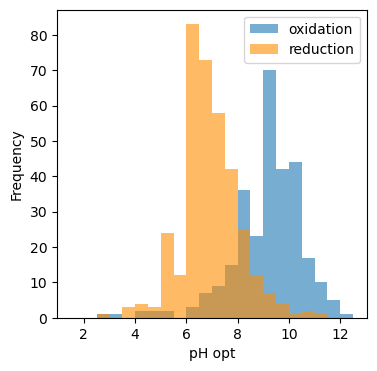

In [145]:
f, ax = plt.subplots(figsize=(4,4))
bins = np.arange(1.5,12.6,0.5)
data_redox_ann[data_redox_ann.reaction_type == "oxidation"].ph_min.plot.hist(
    bins=bins, ax=ax, alpha=0.6, label="oxidation")
data_redox_ann[data_redox_ann.reaction_type == "reduction"].ph_min.plot.hist(
    bins=bins, ax=ax, alpha=0.6, color='darkorange', label="reduction")

ax.legend()
ax.set_xlabel("pH opt")

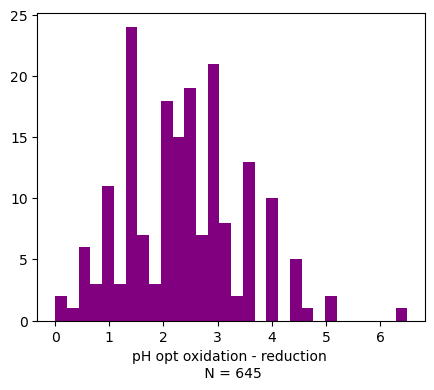

In [170]:
f, ax = plt.subplots(figsize=(5,4))
# bins = np.arange(1.5,12.6,0.5)
df3 = data_redox_ann[data_redox_ann.reaction_type.isin(["oxidation", "reduction"])]
redox_diffs = []
for (ec_num, u_id), df in df3.groupby(["ec_num", "uniprot_id"]):
    ox_ph_opt = df[df.reaction_type == "oxidation"].ph_min.mean()
    red_ph_opt = df[df.reaction_type == "reduction"].ph_min.mean()
    redox_diffs += [ox_ph_opt - red_ph_opt]
    if ox_ph_opt - red_ph_opt < 0:
        print(df)
plt.hist(redox_diffs, bins=30, color="purple")
ax.set_xlabel(f"pH opt oxidation - reduction \n N = {len(df3)}")
plt.show()
plt.close()
# df2 = 
# df2['ph_diff'] = 
#     bins=bins, ax=ax, alpha=0.6, label="oxidation")
# data_redox_ann[data_redox_ann.reaction_type == "reduction"].ph_min.plot.hist(
#     bins=bins, ax=ax, alpha=0.6, color='darkorange', label="reduction")

# ax.legend()
# ax.set_xlabel("pH opt")

### Add the reaction type to each of the rows
- General reaction type
  - Give oxidation, reduction and general oxidoreductase their own category
- Reaction sub-type (second number)
- Acceptor (i.e., third number) for oxidoreductases(?)
  

In [173]:
os.getcwd()

'/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering/notebooks/ph/202308'

In [174]:
os.chdir("../../../")

In [176]:
from src.brenda_enzyme_types import add_enzyme_types

In [185]:
import src.brenda_enzyme_types as bet

In [188]:
from importlib import reload
reload(src.brenda_enzyme_types)

<module 'src.brenda_enzyme_types' from '/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering/src/brenda_enzyme_types.py'>

In [190]:
data_merged = bet.add_enzyme_types(data_merged)

In [191]:
data_merged.head(2)

,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref,ph_range_ref_match,reaction_type,note,cofactor,substrate,enzyme_type,enzyme_type_sub,acceptor
4701,2.1.1.10,homocysteine S-methyltransferase,7.2,-,-,Brassica oleracea,A4ZGQ8,676384,NaN,NaN,NaN,NaN,NaN,Transferases,one-carbon groups,NaN
4702,2.1.1.10,homocysteine S-methyltransferase,7.5,-,-,Arabidopsis thaliana,Q9M1W4,441387,NaN,NaN,NaN,NaN,NaN,Transferases,one-carbon groups,NaN


In [193]:
# manually parse the redox reactions
out_file = Path(data_dir, "ph_opt/20230907_ph_opt_no_ph_range_ez_type.csv")
print(len(data_merged), data_merged.uniprot_id.nunique())
data_merged.to_csv(out_file)

10683 7660
